In [1]:
# Data preparation

import pandas as pd

# Reading csv files
responsories_all = pd.read_csv('all-ci-responsories.csv', usecols=['id', 'cantus_id', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('all-ci-antiphons.csv', usecols=['id', 'cantus_id', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('source.csv', usecols=['id', 'title', 'rism', 'provenance_id', 'century', 'drupal_path'])
feasts = pd.read_csv('feast.csv', usecols=['id', 'name'])
geo_data = pd.read_csv('geography_data.csv', usecols=['provenance_id', 'provenance','latitude', 'longitude'])

# Add sources to data 
respo_with_sources = pd.merge(responsories_all, sources, how='inner', left_on='source_id', right_on='drupal_path')
antipho_with_sources = pd.merge(antiphons_all, sources, how='inner', left_on='source_id', right_on='id')

# Merge responsories and antiphons
data = pd.concat([respo_with_sources, antipho_with_sources])

# Filter sources to avoid working with fragments etc
freq_of_sources = data['drupal_path'].value_counts()
bigger_sources = freq_of_sources.drop(freq_of_sources[freq_of_sources.values < 100].index).index.tolist()
sources_f = sources[sources['drupal_path'].isin(bigger_sources)]

# Filter feasts from filtered sources
freq_of_feasts = data['feast_id'].value_counts()
print("number of all feasts in bigger sources:", len(freq_of_feasts))
bigger_feasts = freq_of_feasts.drop(freq_of_feasts[freq_of_feasts.values < 10].index).index.tolist()
print("number of all bigger feasts in bigger sources:", len(bigger_sources))
feasts_f = feasts[feasts['id'].isin(bigger_feasts)]

# Get data without small sources and feasts
data_f = data[data['drupal_path'].isin(sources_f['drupal_path'])]
data_f = data_f[data_f['feast_id'].isin(feasts_f['id'])]

# Get sources with geographical info
geo_source = pd.merge(sources_f, geo_data, how='inner', left_on='provenance_id', right_on='provenance_id')

number of all feasts in bigger sources: 911
number of all bigger feasts in bigger sources: 131


In [4]:
# Useful functions etc
import numpy as np
# Dicts for feast and source ids
from collections import OrderedDict
source_dict = OrderedDict()
i = 0
for id in sources_f['drupal_path']:
    source_dict[id] = i
    i += 1

feast_dict = OrderedDict()
j = 0
for id in feasts_f['id']:
    feast_dict[id] = j
    j += 1

num_to_feast = OrderedDict()
for k in range(len(feasts_f)):
    num_to_feast[k] = feasts_f['id'].iloc[k]

# Functions translating feast_ids to indexis
def translate_feast(feast_id):
    return feast_dict[feast_id] 

def translate_source(source_id):
    return source_dict[source_id]

# Metrics for measuring similarity of two sets ('chant sharingness')
def intersection_size(a, b):
    return len(set(a) & set(b))

def Jaccard_metrics(a, b):
    if len(set(a) | set(b)) != 0:
        return len(set(a) & set(b)) / len(set(a) | set(b))
    else:
        return 0
    
def get_matrix_of_sources_sharing_chants_one_feast(feast_id, compare_func):
    source_chants_dict = {}
    used_sources = []
    filt_feast = data_f['feast_id'] == feast_id
    chants_of_feast = data_f[filt_feast]
    for source_id in sources_f['drupal_path']:
        filt_source = chants_of_feast['drupal_path'] == source_id
        source_chants_dict[source_id] = (chants_of_feast[filt_source]['cantus_id']).tolist()
        if (chants_of_feast[filt_source]['cantus_id']).tolist() != []:
            used_sources.append(source_id)

    all_pairs = [(a, b) for idx, a in enumerate(sources_f['drupal_path']) for b in sources_f['drupal_path'].tolist()[idx + 1:]]
    data_matrix = np.zeros([len(sources), len(sources)])
    for s_i, s_j in all_pairs:
        data_matrix[translate_source(s_i), translate_source(s_j)] = compare_func(source_chants_dict[s_i], source_chants_dict[s_j])
    
    return data_matrix, used_sources

7
4


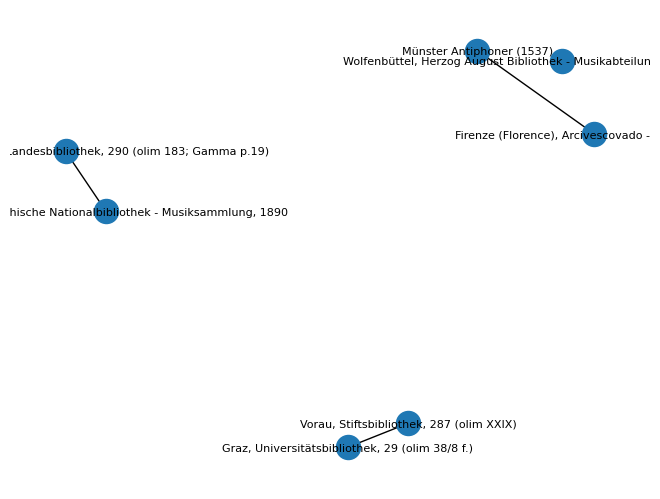

In [9]:
import networkx as nx
import itertools

# Create graph for given feast on ids
# Prokop feast_1412  0 source  --- vs CantusIndex has 49 chants, most antiphones and respons
# Ludmila feast_1085 1 source 
# Vojtech feast_0019  5 source and 2 communities
# Anezka ceska v datech neni ...
# Vaclav feast_1806 5 source and 3 communities
# Vit feast_1794 7 source and 4 communities

given_feast = 'feast_1794'

source_chant_one_feast_mat, used_sources = get_matrix_of_sources_sharing_chants_one_feast(given_feast, Jaccard_metrics)

len_s = len(sources_f)
s1_id_column = list(itertools.chain.from_iterable([len_s * [s] for s in sources_f['drupal_path'].tolist()]))
s2_id_column = len_s * sources_f['drupal_path'].tolist()
s1_tit_column = list(itertools.chain.from_iterable([len_s * [s] for s in sources_f['title'].tolist()]))
s2_tit_column = len_s * sources_f['title'].tolist()
chants_column = []

s1_chants = ...
s2_chants = ...
for i in range(len(s1_id_column)):
    chants_column.append(source_chant_one_feast_mat[translate_source(s1_id_column[i]), translate_source(s2_id_column[i])])

# translate ids to titles
sCh_nodes = []
for node in used_sources:
    node = sources_f[sources_f['drupal_path'] == node]['title'].iloc[0]
    sCh_nodes.append(node)
used_sources = sCh_nodes

sCh_edges = [(i, j, {'weight': w}) for i, j, w in zip(s1_tit_column, s2_tit_column, chants_column) if i != j and (i in used_sources and j in used_sources) and w != 0]


G = nx.Graph()
G.add_nodes_from(sCh_nodes)
G.add_edges_from(sCh_edges)
pos = nx.spring_layout(G, k = 0.6, iterations=50)
nx.draw(G, pos=pos, with_labels = True, font_size = 8)

communit_tit = nx.community.louvain_communities(G, weight='weight') #list of sets

print(len(used_sources))
print(len(communit_tit))